# Blank Factory

## Subroutines

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cmath import pi,acos,exp,sqrt
def plotArc(ax,P0,n0,l,da,*args,tol=0.001,**kwargs):
  if l==0:
    return
  x=np.linspace(0,l,max(2,int(abs(6*(da/(2*pi)))),int(l//(2*abs(2*l/da*tol)**0.5)+1))if (da!=0) and (l!=0) else 2)
  phi2=x/l*da/2
  p=P0+x*np.sinc(phi2/pi)*n0*np.exp(1j*phi2)
  ax.plot(p.real,p.imag,*args,**kwargs)
    
def plotArcchain(ax,P0,n0,arcs,*args,**kwargs):
    p=P0
    n=n0
    for l,da in arcs:
        plotArc(ax,p,n,l,da,*args,**kwargs)
        p+=l*np.sinc(da/(2*pi))*n*exp(1j*da/2)
        n*=exp(1j*da)
        
def calcTangent(c1,r1,c2,r2):
    c2_c1=(c2-c1)
    lcc=abs(c2_c1) 
    ec2_c1=c2_c1/lcc
    cosphi=((r1+r2)/lcc)
    phi=-cosphi+1j*(1-cosphi**2)**0.5
    t1=c1-r1*ec2_c1*phi
    t2=c2+r2*ec2_c1*phi
    return [t1,t2]
    
        
def pipe(*f):#reverses the order of chained function calls: f3(f2(f1(x))) = pipe(f1,f2,f3)(x)
  if len(f)==0:
    def g(*x):
      return None
  else:
    def g(*x):
      x=f[0](*x)
      for fi in f[1:]:
        if fi==None:
            continue
        x=fi(x)
      return x
  return g
  
      
def iterize(f):
    if f==None:
      def wrapper(*args,**kwargs):
        if len(args)==0:
           return None
        else:
           return args[0]
    else:  
      def wrapper(*args,**kwargs):
        if len(args)==0:
            return f(**kwargs)
        else: 
            t=args[0]
            return (f(t_,*args[1:],**kwargs) for t_ in t) if hasattr(t,'__next__') else f(*args,**kwargs)
      wrapper.__name__='iterized_'+f.__name__
    return wrapper

In [2]:
class NamedList(list): 
    '''
    A mutable version of namedtuple.
    '''
    def __init__(self,*args,**kwargs):
        super().extend(args)
        super().__setattr__('_lookup',dict())
        self._lookup.update({ f'_{i}':i for i in range(len(self))})
        self.update(**kwargs)
    def __setattr__(self,name,value):
           self.update(**{name:value})
    def __getattr__(self,name):
        try: 
          return self.__getitem__(self._lookup[name])
        except:
          raise AttributeError(f"Found no attribute named '{name}'.  ")
    def append(self,value):
        raise IndexError(f"Use the 'update' method to add elements to a {self.__class__.__name}!") 
    def extend(self,value):
        raise IndexError(f"Use the 'update' method to add elements to a {self.__class__.__name}!") 
    def update(self,*args,**kwargs): 
        if len(args)>0:
           if len(args)>len(self):
              self[:]=args[:len(self)]
              self._lookup.update({f'_{i}':i for i in range(len(self),len(args))})
              super().extend(args[len(self):])
           else:
              self[:len(args)]=args
        for name,value in kwargs.items():
            if  not name in self._lookup:
                if name[0]=='_':
                    new_index=int(name[1:])
                    self._lookup.update({f'_{i}':i for i in range(len(self),new_index+1)})
                    super().extend([None]*(new_index-len(self)+1))
                    self[new_index]=value
                    KeyError(f"Error in 'update': Field '{name}' does not exist.")
                else:
                   self._lookup[f'_{len(self)}']=len(self)
                   self._lookup[name]=len(self)
                   super().append(value)
            else:
                self.__setitem__(self._lookup[name],value)
        return self
    def alias(self,aliases):
        for name,alias in aliases.items():
            if type(alias)!=str:
                raise KeyError(f"Error in 'alias': Field name '{alias}' must be a  valid variable name.")
            if alias[0]=='_':
                raise KeyError(f"Error in 'alias': Field name '{alias}' must not start with an underscore ('_').")
            if alias in self._lookup:
                if self._lookup[alias]==self.lookup[name]:
                    return
                else:
                    raise KeyError(f"The alias name '{alias}' is already used for a different field.")
            self._lookup[alias]=self._lookup[name]
    def rename(self,substitutions):
        for old_name,new_name in substitutions.items():
            if old_name[0]=='_':
                raise KeyError(f"The name '{old_name}' cannot be renamed.")
            
            if (new_name!=None) and (new_name[0]=='_'):
                raise KeyError(f"Error in 'rename': Field name '{new_name}' must not start with an underscore ('_').")
            old_index=self._lookup.pop(old_name,None)
            if old_index==None:
                raise KeyError(f"The name '{old_name}' does not exist.")
            if new_name in self._lookup:
                if self._lookup[new_name]==old_index:
                    return
                else:
                    raise KeyError(f"The name '{alias}' is already used for a different member of the list.")
            if new_name!=None:
                self._lookup[new_name]=old_index
    def __repr__(self):
        args=", ".join(f'{key}={value}' for key,value in self.as_dict().items())
        return f'{self.__class__.__name__}({args})' 
    def as_dict(self):
        key_for_index={index:key for key,index in self._lookup.items()}
        return {key_for_index.get(index,index):value for index,value in enumerate(self)}
    def copy(self):
        myCopy=self.__class__.from_list(self)
        myCopy._lookup.update(self._lookup)
        return myCopy

In [3]:
nl=NamedList(1,2,3,10,56)
nl


NamedList(_0=1, _1=2, _2=3, _3=10, _4=56)

In [4]:
class dataobj(object):
  def __init__(self,*args,**kwargs):
    self.__dict__.update(**kwargs)
  def __getitem__(self,name):
    return self.__dict__[name]
  def __setitem__(self,name,value):
    if type(name)!=str: raise NameError()
    self.__dict__[name]=value
  @property
  def x(self):
    if not hasattr(self,'p'): raise AttributeError("'dataobj' object has no attribute 'x'")
    return self.p.real
  @x.setter
  def x(self,value):
    if not hasattr(self,'p'): self.p=0.0+0.0j
    self.p=value+1j*self.p.imag
     
  @property 
  def y(self):
    if not hasattr(self,'p'): raise AttributeError("'dataobj' object has no attribute 'y'")
    return self.p.imag
  @y.setter
  def y(self,value):
     if not hasattr(self,'p'): self.p=0.0+0.0j
     self.p=self.p.real+1j*value

In [5]:
from bisect import bisect_right

def binary_search(a, x, lo=0, hi=None):   # can't use a to specify default for hi
    hi = hi if hi is not None else len(a) # hi defaults to len(a)   
    pos = bisect_left(a,x,lo,hi)          # find insertion position
    return pos # don't walk off the end
def index_frac(x,ax):
    idx=bisect_right(ax,x,1,len(ax)-1)
    return idx-1,(x-ax[idx-1])/(ax[idx]-ax[idx-1])
def interp(x,ax,ay):
    idx=bisect_right(ax,x,1,len(ax)-1)
    return ay[idx-1]+(x-ax[idx-1])/(ax[idx]-ax[idx-1])*(ay[idx]-ay[idx-1])
def cumsum(x,x_start=None):
    if x_start!=None:
        csum=[x_start]+x.copy()
    else:
        csum=x.copy()
    for i in range(1,len(csum)):
        csum[i]+=csum[i-1]
    return csum
        

In [6]:
#interpSegments, Segments2Complex
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi,exp,sign,inf

def polygonArea(p):
  def crossprod(v1,v2):
    return v1.real*v2.imag-v2.real*v1.imag
  return 0.5*np.sum(crossprod(p[range(-1,len(p)-1)],p))

def SegmentsLength(Segs):
    return sum(l for l,*_ in Segs)

def SegmentsArea(Segs):
  nSegs=len(Segs)
  dl,dang,*opts=np.array(Segs).transpose()
  ang=np.cumsum(dang)
  ang=exp(1j*np.insert( ang,0,0))
  dang_2=np.exp(1j*dang/2)
  viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
  pSeg=np.cumsum(viSeg)
  olderr=np.geterr()
  np.seterr(divide='ignore',invalid='ignore')#suppress the warnings from 0/0 = nan. nansum assumes nan=0, which is the correct value in this case
  area=polygonArea(pSeg) +  np.nansum((dl/dang)**2*(dang/2.0-dang_2.real*dang_2.imag))
  np.seterr(**olderr)
  return area

def InterpSegments(Segs,t,p0=0.+0.j,a0=0+1j,scale=1.0,eps=1e-6):
  """
  Segment points are calculated for values of 't', where 't' is the normalized
  length of the path. t is in the range of [0..1[
  """
  dl,dang=np.array([(l,a) for l,a,*_ in Segs]).transpose()
  L=np.cumsum(np.insert(dl,0,0.0))
  ang_=np.cumsum(np.insert(dang,0,0.0))
  ang=exp(1j*ang_)
  viSeg=np.sinc(dang/(2*pi))*dl*scale*np.exp(1j*dang/2)*ang[:-1]
  pSeg=np.cumsum(np.insert(viSeg,0,0+0j))
  if not hasattr(t,'__getitem__'): #not an array
    t=np.array([t]) #convert to array
  else:
    if t.shape==(): #no dimensions
      t=np.array([t])
    else:
      t=np.array(t)
  T=t.astype(int)
#  t=t-T
  if ((abs(pSeg[-1])<eps) and (abs(ang[-1]-(1+0j))<eps)):
    pr,ar=np.zeros((len(t),),dtype=complex), np.ones((len(t),),dtype=complex) # closed loop. No translation/rotation necessary for t>1
  else: #endpoint of path != startpoint => repeat path for t>1 by translating and rotating it
    def rotateSecant(v,beta,T):
      beta2=beta/2
      rot2=exp(1j*beta2)
      uniqueT,inverseIndex=np.unique(T,return_inverse=True) #don't re-calculate for identical values of T
      p=(v*rot2**(uniqueT-1)/nsinc(beta2/np.pi) * uniqueT * np.sinc(uniqueT*beta2/np.pi))[inverseIndex]
      a=(rot2**(2*uniqueT))[inverseIndex]
      return p,a
    pr,ar=rotateSecant(pSeg[-1]*a0,ang_[-1],T)
  pr+=p0
  ar*=a0
  l=L/L[-1]
  Xx=np.interp(t-T,l,range(len(l)))
  X=np.maximum(0,np.minimum(Xx.astype(int),len(dang)-1)) #segment index
  x=Xx-X#within seggment
  p=pSeg[X] + np.sinc( dang[X]*x /(2*pi))* dl[X]*x *scale*np.exp(1j* dang[X]*x /2)*ang[X]
  p=p*ar+pr
  a=ang[X]*np.exp(1j*dang[X]*x)*ar
  if len(p)==1:
      p=p[0] #convert array to single value if argument was a single value
      a=a[0]
  return p,a,L[-1]*t,X

def Segments2Complex(Segs,p0=0.+0.j,scale=1.0,a0=0+1j,tol=0.05,offs=0,loops=1,return_start=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0
  p=p0
  p-=1j*a*offs
  L=0
  if return_start:
      yield p,a,L,-1 #assuming closed loop: start-point = end-point
  loopcount=0
  while (loops==None) or (loops==inf) or (loopcount<loops):
      loopcount+=1
      for X,(l,da,*_) in enumerate(Segs):
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for i in range(n):
          L+=l/n
          p+=v
          yield p,a,L,X
          v*=dda
          a*=dda

In [7]:
import math, cmath
def sinc(alpha):
  return 1.0 if alpha==0 else math.sin(alpha)/alpha
def arcChainInterpolator(t=None,/,*,arcChain,p0=0.+0.j,a0=0+1j,scale=1.0,eps=1e-6):
  """
  Segment points are calculated for values of 't', where 't' is the normalized
  length of the path. t is in the range of [0..1[
  """
  dl,dang=np.array([(l,a) for l,a,*_ in arcChain]).transpose()
  L=np.cumsum(np.insert(dl,0,0.0))
  l=L/L[-1]
  ang_=np.cumsum(np.insert(dang,0,0.0))
  ang=exp(1j*ang_)
  viSeg=np.sinc(dang/(2*pi))*dl*scale*np.exp(1j*dang/2)*ang[:-1]
  pSeg=np.cumsum(np.insert(viSeg,0,0+0j))
  viSeg=list(viSeg)
  pSeg=list(pSeg)
  dang=list(dang)
  ang_=list(ang_)
  ang=list(ang)
  L=list(L)
  l=list(l)
  l_idx=list(range(len(l)))
  def interpolateArcChain(t,/):
      T=int(t)
    #  t=t-T
      if ((abs(pSeg[-1])<eps) and (abs(ang[-1]-(1+0j))<eps)):
        pr,ar=0.0+0.0j,1.0+0.0j
      else: #endpoint of path != startpoint => repeat path for t>1 by translating and rotating it
        def rotateSecant(v,beta,T):
          beta2=beta/2
          rot2=exp(1j*beta2)
          p=(v*rot2**(T-1)/sinc(beta2) * T * sinc(T*beta2))
          a=(rot2**(2*T))
          return p,a
        pr,ar=rotateSecant(pSeg[-1]*a0,ang_[-1],T)
      pr+=p0
      ar*=a0
#      Xx=np.interp(t-T,l,l_idx)
#      X=max(0,min(int(Xx),len(dang)-1)) #segment index
#      x=Xx-X#within seggment
      X,x=index_frac(t-T,l)
      p=pSeg[X] + sinc( dang[X]*x/2)* dl[X]*x *scale*cmath.exp(1j* dang[X]*x /2)*ang[X]
      p=p*ar+pr
      a=ang[X]*cmath.exp(1j*dang[X]*x)*ar
      return p,a,L[-1]*t,X
  return interpolateArcChain
#  return interpolateArcChain(t) if t!=None else interpolateArcChain

In [8]:
def ISO_thread(z=None,/,phi=0.0,*,Pitch,External=False):
    tan60=3**0.5
    cos60=0.5
    sin60=tan60*cos60
    Pitch2=Pitch/2
    H=(Pitch2)*tan60
    flank_start=Pitch2/8
    r_maj=flank_start/sin60
    r_maj2=r_maj**2
    c_maj=-flank_start/tan60
    r_min=2*r_maj    
    r_min2=r_min**2
    c_min=-5/8*H+Pitch2/4/tan60
    flank_end=(3/4)*Pitch2
    if External:
        def ISO_thread_(z,/,phi=phi,*_,**__):
            dz=abs((z-phi*Pitch+Pitch2)%Pitch-Pitch2)#use symmetries
            if dz<flank_start:
                return 0.0
            if dz<=flank_end:
                return -tan60*(dz-flank_start)
            return  (c_min-(r_min2-(Pitch2-dz)**2)**0.5)
    else:# internal thread
        def ISO_thread_(z,/,phi=phi,*_,**__):
            dz=abs((z-phi*Pitch+Pitch2)%Pitch-Pitch2)#use symmetries
            if dz<flank_start:
                return c_maj+(r_maj2-dz**2)**0.5
            if dz<=flank_end:
                return -tan60*(dz-flank_start)
            return -5/8*H
    return ISO_thread_(z) if z!= None else ISO_thread_


In [9]:
def arcsFromSpec(*,r_rim, r_hub, n_spokes, n_strands,phi_rim, r_fillet_rim, phi_hub, r_fillet_hub):
    import cmath
    from cmath import pi
  #geometry of the mesh:
    phi_tot=2*pi*n_strands
    phi_spoke2=phi_tot/(2*n_spokes)#angle be
    l1,r1,l2,r2=phi_rim*phi_spoke2*r_rim,r_fillet_rim*phi_spoke2*r_rim,phi_hub*phi_spoke2*r_hub,r_fillet_hub*phi_spoke2*r_hub
    c1=(0-1j*(r_rim-r1))*cmath.exp(1j*phi_rim*phi_spoke2)#center of the rim fillet
    c2=(0-1j*(r_hub+r2))*cmath.exp(1j*((1-phi_hub)*phi_spoke2))#center of the hub fillet
    t1,t2=calcTangent(c1,r1,c2,r2)#end points of tangent between fillet1 and fillet 2
    ltan,phitan=cmath.polar(t2-t1)
    phitan%=2*pi #counter-clockwise 0-360deg
    arcs=[(l1,phi_rim*phi_spoke2),(r1*(phitan-phi_rim*phi_spoke2),phitan-phi_rim*phi_spoke2),(ltan,0),(r2*(phitan-((1-phi_hub)*phi_spoke2)),-phitan+((1-phi_hub)*phi_spoke2)),(l2,phi_hub*phi_spoke2)]
    return arcs


### linear mesh

In [10]:
import matplotlib.pyplot as plt
import matplotlib
import numpy
import cmath  
    
%matplotlib notebook

linearData=dict(l1=0.15, r1=0.1, l2=0.15, r2=0.1,strands=5)
def update_linear_plot(l1,r1,l2,r2,strands,**kwargs):
  output1.clear_output(wait=True)
  with output1:
    %matplotlib inline
    fig=plt.figure(figsize=(3,3)) 
    ax=fig.add_subplot(1,1,1)  
    plotArcchain(ax,0+0j,1+0j,((l1,0),(r1*2*pi,2*pi)))
    c1=l1+1j*r1
    ax.plot(c1.real,c1.imag,('k+'))
    plotArcchain(ax,1+1j,-1+0j,((l2,0),(r2*2*pi,2*pi)))
    c2=(1-l2)+1j*(1-r2)
    ax.plot(c2.real,c2.imag,'k+') 
    t1,t2=calcTangent(c1,r1,c2,r2)
    ax.plot([t1.real,t2.real],[t1.imag,t2.imag])  
    ax.set_aspect('equal')
    ax.set_aspect(1.0)
    display(fig)
    plt.close()
  output2.clear_output(wait=True)
  with output2:
    fig=plt.figure(figsize=(12,3 )) 
    ax=fig.add_subplot(1,1,1)  
    ltan,phitan=cmath.polar(t2-t1)
    phitan%=2*pi
    arcs=[(l1,0),(r1*phitan,phitan),(ltan,0),(r2*phitan,-phitan),(l2,0)]
    arcs=(arcs+arcs[-1::-1])*2
    for i in range(strands):
      p0=2*i/strands+0j
      n0=1+0j
      plotArcchain(ax,p0,n0,arcs,c=['r','g','b','y','k'][i])
    ax.set_xlim(0,4)
    ax.set_aspect('equal')
    display(fig)
    plt.close()
  output3.clear_output(wait=True)
  with output3:
    print(f'{l1=:0.3f}, {r1=:0.3f}, {l2=:0.3f}, {r2=:0.3f}, {strands=:d}')
    print(f'mesh={arcs[:5]}')
  plt.close()

from ipywidgets import widgets,HBox,VBox
output1=widgets.Output() 
output2=widgets.Output()
output3=widgets.Output()
def handle_linearChange(msg):
  linearData[msg['owner'].description] = msg['new']
  update_linear_plot(**linearData)

widgetList1=dict()

for key,value in linearData.items():
    if type(value)==float:
      widgetList1[key]=widgets.FloatSlider(description=key,
            min=0.0,max=1.0,value=value,step=0.01,continuous_update=False, orientation='horizontal',layout={'width':'5in'},
            readout_format='0.3f')
    else:
      widgetList1[key]=widgets.BoundedIntText(description=key,
            min=1,max=5,value=value,step=1,continuous_update=False,layout={'width':'1.5in'},
            readout_format='d')
    widgetList1[key].observe(handle_linearChange,'value')

Layout1=VBox(
        [
        HBox([VBox([widgets.HTML(value="<h2>Parameters</h2>"),widgetList1['l1'], widgetList1['r1'],widgetList1['l2'],widgetList1['r2'],widgetList1['strands']],), output1,],),
        output2,
        output3
        ])
update_linear_plot(**linearData);

### circular mesh

In [11]:
from cmath import pi
circularData=dict(r_rim= 10.000, r_hub=3.500, n_spokes=13, n_strands=5,
                  phi_rim=0.160, r_fillet_rim=0.060, phi_hub=0.050, r_fillet_hub=0.200,)

deg=pi/180.0               

def update_circular_plot(*args,r_rim, r_hub, n_spokes, phi_rim, r_fillet_rim, phi_hub, r_fillet_hub, n_strands,**kwargs):#all arguments are required keyword arguments. additional arguments are allowed
  output4.clear_output(wait=True)
  phi_tot=2*pi*n_strands
  phi_spoke2=phi_tot/(2*n_spokes)
  l1,r1,l2,r2=phi_rim*phi_spoke2*r_rim,r_fillet_rim*phi_spoke2*r_rim,phi_hub*phi_spoke2*r_hub,r_fillet_hub*phi_spoke2*r_hub
  with output4:
    %matplotlib inline
    fig=plt.figure(figsize=(4,4)) 
    ax=fig.add_subplot(1,1,1)  
    if phi_spoke2>60*deg:
        ax.plot(0,0,'+')
    for phi in np.exp(1j*np.linspace(0,phi_spoke2,2)):
      p1=-1.0j*(r_hub-0.2*(r_rim-r_hub))*phi
      p2=-1.0j*(r_rim+0.2*(r_rim-r_hub))*phi
      ax.plot((p1.real,p2.real),(p1.imag,p2.imag),'k-.',lw=1)
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    plotArcchain(ax,0-1j*r_rim,1+0j,((l1,phi_rim*phi_spoke2),(r1*2*pi,2*pi)))
    c1=(0-1j*(r_rim-r1))*exp(1j*phi_rim*phi_spoke2)
    ax.plot(c1.real,c1.imag,('k+'))
    plotArcchain(ax,(0-1j*r_hub)*exp(1j*phi_spoke2),(-1+0j)*exp(1j*phi_spoke2),((l2,-phi_hub*phi_spoke2),(r2*2*pi,2*pi)))
    c2=(0-1j*(r_hub+r2))*exp(1j*((1-phi_hub)*phi_spoke2))
    ax.plot(c2.real,c2.imag,'k+') 
    t1,t2=calcTangent(c1,r1,c2,r2)
    ax.plot([t1.real,t2.real],[t1.imag,t2.imag])  
    ltan,phitan=cmath.polar(t2-t1)
    phitan%=2*pi #counter-clockwise 0-360deg
    arcs=[(l1,phi_rim*phi_spoke2),(r1*(phitan-phi_rim*phi_spoke2),phitan-phi_rim*phi_spoke2),(ltan,0),(r2*(phitan-((1-phi_hub)*phi_spoke2)),-phitan+((1-phi_hub)*phi_spoke2)),(l2,phi_hub*phi_spoke2)]
    arcs=(arcs+arcs[-1::-1])# add mirrored arc sequence
    for i in range(n_strands):
        dphi=2*phi_spoke2/n_strands
        phi=exp(-1j*dphi*(i+1))
        plotArcchain(ax,(-1j*r_rim)*phi,(1+0j)*phi,arcs*2,c='lightgray',zorder=-1)
    if n_strands<2:
      for r in [r_hub,r_rim]:
        p=-1j*r*np.exp(1j*np.linspace(0,phi_spoke2,25))
        ax.plot(p.real,p.imag,c='lightgray',lw=1,zorder=-1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    ax.set_aspect(1.0)
    display(fig)
    plt.close()
  output5.clear_output(wait=True)
  with output5:
    fig=plt.figure(figsize=(6,6)) 
    ax=fig.add_subplot(1,1,1)  
    p0=0-1j*r_rim
    n0=1+0j
    plotArcchain(ax,p0,n0,arcs*n_spokes,c='b')
    ax.plot([xlim[0],xlim[1],xlim[1],xlim[0],xlim[0]],[ylim[0],ylim[0],ylim[1],ylim[1],ylim[0]],'--',c='gray',lw=1)
    ax.set_aspect('equal')
    display(fig)
    plt.close()
  output6.clear_output(wait=True)
  with output6:
    from math import gcd
    if  gcd(n_strands,n_spokes)!=1:
        print('\x1b[31m'+f'n_strands and n_spokes are not coprime: {gcd(n_strands,n_spokes)=} (should be 1)'+'\x1b[0m')
    print(f'{r_rim=: 0.3f}, {r_hub=:0.3f}, {n_spokes=:d}, {n_strands=:d},')
    print(f'{phi_rim=:0.3f}, {r_fillet_rim=:0.3f}, {phi_hub=:0.3f}, {r_fillet_hub=:0.3f},')
    print()
    print(f'mesh={arcs[:5]}')
    
  plt.close()

from ipywidgets import widgets,HBox,VBox
output4=widgets.Output() 
output5=widgets.Output()
output6=widgets.Output()

def handle_circularChange(msg):
  circularData[msg['owner'].description] = msg['new']
  update_circular_plot(**circularData)
    
widgetList2={}
for key,value in circularData.items():
    if type(value)==int:
        widgetList2[key]=widgets.IntText(description=key, value=value,layout={'width':'1.5in'}, readout_format='d')
    elif type(value)==float:
        widgetList2[key]=widgets.FloatText(description=key, value=value,layout={'width':'1.5in'}, readout_format='0.3f')
    else: print(f'need to add widget for {key=}, {type(value)=}');continue
    widgetList2[key].observe(handle_circularChange,'value')

Layout2=VBox(
        [HBox([
        VBox([HBox([VBox([widgetList2['r_rim'],widgetList2['r_hub'],widgetList2['n_spokes'],widgetList2['n_strands']],),VBox([widgetList2['phi_rim'], widgetList2['r_fillet_rim'],widgetList2['phi_hub'],widgetList2['r_fillet_hub'],]),],),
             output4]),
        output5,]),
        output6
        ])
update_circular_plot(**circularData);
plt.close()

In [12]:
#transformer, rotor,...
def mesh_transformer(*,r_rim,r_hub,outline,p0o,n0o,outline_stretch=None,inline,p0i,n0i,inline_stretch=None,finline_offset=lambda *_:0.0,foutline_offset=lambda *_:0.0,**kwargs):
    import cmath
    unstretched_outline=cumsum([l for l,*_ in outline],0.0)
    unstretched_outline=[x/unstretched_outline[-1] for x in unstretched_outline]
    outlineInterpolator_=arcChainInterpolator(arcChain=outline,p0=p0o,a0=n0o)
    if outline_stretch!=None:
        stretched_outline=cumsum([l/s for (l,*_),s in zip(outline,outline_stretch)],0.0)
        stretched_outline=[x/stretched_outline[-1] for x in stretched_outline]
        outlineInterpolator=lambda T_mesh:outlineInterpolator_(interp(T_mesh,stretched_outline,unstretched_outline))
    else:
        outlineInterpolator=outlineInterpolator_
    unstretched_inline=cumsum([l for l,*_ in inline],0.0)
    unstretched_inline=[x/unstretched_inline[-1] for x in unstretched_inline]
    inlineInterpolator_=arcChainInterpolator(arcChain=inline,p0=p0i,a0=n0i)
    if inline_stretch!=None:
        stretched_inline=cumsum([l/s for (l,*_),s in zip(inline,inline_stretch)],0.0)
        stretched_inline=[x/stretched_inline[-1] for x in stretched_inline]
        inlineInterpolator=lambda T_mesh:inlineInterpolator_(interp(T_mesh,stretched_inline,unstretched_inline))
    else:
        inlineInterpolator=inlineInterpolator_
    def transform_mesh(pz,/):
      p=pz[0]
      #transform raw mesh to tripod shape: 
      T_mesh=(cmath.polar(p)[1]/(2*pi))%1.0 #phase angle of mesh points [0..1[
      r_mesh=abs(p)#amplitude of mesh points
      pout,aout,Lout,*_=outlineInterpolator(T_mesh)
      pout+=aout*1j*foutline_offset(pz[1],Lout)
      pin,ain,Lin,*_=inlineInterpolator(T_mesh)
      pin+=ain*1j*finline_offset(pz[1],Lin)
      p_transformed_point=pin+(pout-pin)*((r_mesh-r_hub)/(r_rim-r_hub)) #transform raw mesh to tripod shape
      pz[0]=p_transformed_point
      return pz
    return transform_mesh
        
def calibrator(*,p_center=0.0+0.0j,r_ref,dr_offset=0.0,f_offset=None,dr_rigid=0.0,mesh_compression=2.0,ew_factor=None,**kwargs):
    import cmath
    r_rigid_max=r_ref+dr_rigid
    r_rigid_min=r_ref-dr_rigid
    def calibrate(p_z_ew,/):
        p=p_z_ew[0]
        dr=dr_offset
        if ew_factor!=None:
            dr+=p_z_ew[2]*ew_factor
        dp=p-p_center
        r=abs(dp)
        if f_offset==None:
            r_max=r_rigid_max+dr/2+abs(dr)*(0.5+1/(mesh_compression-1))
            r_min=r_rigid_min+dr/2-abs(dr)*(0.5+1/(mesh_compression-1))
            if (r>r_max) or (r<r_min): 
                return p_z_ew#return early if point is outside the affected zone
        phi=dp/r
        if f_offset!=None:
            dr+=f_offset(p_z_ew[1],(cmath.polar(phi)[1]/(2*pi))%1,r=r_ref)
            r_max=r_rigid_max+dr/2+abs(dr)*(0.5+1/(mesh_compression-1))
            r_min=r_rigid_min+dr/2-abs(dr)*(0.5+1/(mesh_compression-1))
            if (r>r_max) or (r<r_min): 
                return p_z_ew#return early if point is outside the affected zone
        if r_rigid_min < r <r_rigid_max: #just shift the point if it is in the rigid zone
            p_z_ew[0]+=dr*phi
            return p_z_ew
        if r>r_ref:#scale the amout of shift down to zero towards r_max
            if (r_max-r_rigid_max)!=0.0: 
              x=(r_max-r)/(r_max-r_rigid_max)
              p_z_ew[0]=p_center+(r_max - x*(r_max - (dr+r_rigid_max)))*phi
            return p_z_ew
        else: #(r<=r_ref) scale the amount of shift down to zero towards r_min
            if (r_rigid_min-r_min)!=0.0: 
              x=(r-r_min)/(r_rigid_min-r_min)
              p_z_ew[0]=p_center+(r_min + x*((dr+r_rigid_min)-r_min))*phi
            return p_z_ew
    return calibrate

    
def rotor(*,center=0+0j,angle=None,phase=None,fphase=None,**kwargs):
    if fphase != None:
        def rotate(pz,/):
           pz[0]=center+(pz[0]-center)*fphase(pz[1],pz)
           return pz
    else: 
        if angle!=None:
            phase=1j**(angle*2/pi)#same as cmath.exp(1j*angle), but without cmath
        if phase == None:
            raise Exception("Argunent error in call to 'rotor': one of the arguments {phase|angle|fphase} is required") 
        def rotate(pz,/):
            pz[0]=center+(pz[0]-center)*phase
            return pz
    return rotate
    
def terminator(stopcondition=lambda *_:False):
    def checkterm(p,/):
        for x in p:
            if stopcondition(x):
                return
            else:
                yield x
        return
    def terminate(p,/):
        if hasattr(p,'__next__'):
            return checkterm(p)
        else:
            return p
    return terminate


## Tripod 

In [13]:
from cmath import pi
import cmath
import math
from functools import partial
tripodData=dict(r_rim= 35.000, r_hub=31.000, n_spokes=63, n_strands=5,
                phi_rim=0.160, r_fillet_rim=0.060, phi_hub=0.160, r_fillet_hub=0.060,
                ew_rim=1.0,ew_fillet_rim=0.8,ew_spokes=0.7,ew_fillet_hub=0.5,ew_hub=0.5,
                L=35.000, R1=11.000, R2=4.000, R3=8.000, R4=8.000, R5=26.000,
                sL=1.000, sR1=1.500, sR2=0.450, sR3=1.000, sR4=0.700, sR5=0.800,
                z_=0.4,h=8,w_chamfer=1.0,w_chamfer1=6.5,w_chamfer1_bottom=0.3,R1_tolerance=0.2,ew_factor=0.5,
                n_skirt=3,skirt_offset=1.0,R2_tolerance=0.25,hl=0.2,hl_start=0.05)

deg=pi/180.0               
def Tripod(     z_=None,*,#keywords only from here on
                r_rim= 35.000, r_hub=31.000, n_spokes=63, n_strands=5,
                phi_rim=0.160, r_fillet_rim=0.060, phi_hub=0.160, r_fillet_hub=0.060,
                ew_rim=1.0,ew_fillet_rim=0.8,ew_spokes=0.7,ew_fillet_hub=0.5,ew_hub=0.5,
           
                L=35.000, R1=11.000, R2=4.000, R3=8.000, R4=8.000, R5=26.000,
                sL=1.000, sR1=1.500, sR2=0.450, sR3=1.000, sR4=0.700, sR5=0.800,
                h=8,w_chamfer=1.0,w_chamfer1_bottom=0.3,w_chamfer1=6.5,R1_tolerance=0.2,ew_factor=0.5,
                n_skirt=0,skirt_offset=1.0,R2_tolerance=0.25,hl=0.2,hl_start=0.05,
                env=None,**kwargs):
    import math
    from math import pi
    deg=pi/180
  #geometry of the mesh:
    arcs=arcsFromSpec(r_rim=r_rim, r_hub=r_hub, n_spokes=n_spokes, n_strands=n_strands,
                      phi_rim=phi_rim, r_fillet_rim=r_fillet_rim, phi_hub=phi_hub, r_fillet_hub=r_fillet_hub)
    assert len(arcs)==5,f'The unit cell of the mesh should have 5 segments, but it has {len(arcs)} segments!'
    l_layer=sum(l for l,*_ in arcs)*2*n_spokes #extrusion path length for one complete layer (used to calculate z-coordinate)
    arcs=(arcs+arcs[-1::-1])# add mirrored arc sequence

  #lookup table for the extrusion widths:
    arc_ew=[ew_rim,ew_fillet_rim,ew_spokes,ew_fillet_hub,ew_hub]#extrusion widths for rim...hub arc segments
    arc_ew=arc_ew+arc_ew[-1::-1]#mirror the 5 segments
    
  #outer surface of the deformed mesh:
    p0o=L+R3+0j
    n0o=0+1j
    def sss(c,a,b):          #triangle with 3 sides: return angle opposite first side 'c'
      cosgamma=(a**2+b**2-c**2)/(2*a*b)
      return math.acos(cosgamma)
    phi3=180*deg-sss(R5+R4,L,R3+R4) #angle for R3
    phi4=sss(L,R5+R4,R3+R4)         #angle for R4
    phi5=60*deg-sss(R3+R4,L,R5+R4)  #angle for R5
    outline=[(R3*phi3,phi3),(R4*phi4,-phi4),(R5*phi5,phi5)]#turtle path for 1/6 of the outline
    outline+=outline[-1::-1]#mirror to get 1/3 of the outline
    outline*=3 #repeat 3 times to get the complete closed outline turtle path
    
 #inner surface of the deformed mesh:
    p0i=L+R2+0j
    n0i=0+1j
    inline=[(R2*180*deg,180*deg),(0,-90*deg),(L-R2-R1,0),(0,-90*deg),(R1*60*deg,60*deg)]# 1/6 of inside path
    inline+=inline[-1::-1]# add mirrored path
    inline*=3 #repeat 3 times
    
 #stretch factors for inline/outline:
    outline_stretch=[sR3,sR4,sR5]
    outline_stretch+=outline_stretch[-1::-1]
    outline_stretch*=3
    inline_stretch=[sR2,1,sL,1,sR1]#there are 2 90° turns in the path which cannot be stretched
    inline_stretch+=inline_stretch[-1::-1]
    inline_stretch*=3
#1. generate the points of the raw annular mesh:
    blank_points=lambda:Segments2Complex(arcs,p0=r_rim+0.j,a0=0+1j,tol=0.005,return_start=True,loops=n_spokes if z_!=None else math.inf)
#4. rotate the mesh (helical spokes):
    twist_mesh=iterize(rotor(fphase=lambda z,*_:1j**(z/h/n_spokes*4)))
#5. deform the annular mesh to fit between 'inline' and 'outline', and top/bottom chamfer the outside outline:
    transform_mesh=iterize(mesh_transformer(r_rim=r_rim,r_hub=r_hub, 
                                  outline=outline,p0o=p0o,n0o=n0o,outline_stretch=outline_stretch,
                                  foutline_offset=lambda z,*_,**__:max(0,w_chamfer-z,w_chamfer-(h-z)),
                                  inline=inline,p0i=p0i,n0i=n0i,inline_stretch=inline_stretch,))
    point_data=NamedList(p=None,z=None,ew=None,a=None)
    stopcondition=lambda p_z_ew: p_z_ew[1] > (h+hl) 
    meshpoints=lambda:pipe(
      #2. calculate the z-coordinate based on the total extrusion length, re-arrange the variables:
#           iterize(lambda palx:list((palx[0],z_ if z_!=None else hl*palx[2]/l_layer+hl_start,arc_ew[palx[3]],palx[1],))), 
           iterize(lambda palx:point_data.update(p=palx[0],z=z_ if z_!=None else hl*palx[2]/l_layer+hl_start,ew=arc_ew[palx[3]],a=palx[1],)), 
      #3. check if the top (z=h+hl) is reached, and end the iteration if this is the case:
           terminator(stopcondition=stopcondition), 
           twist_mesh,
           transform_mesh,
      #6. counter-sink the 3 'R2' holes:
           *(iterize(calibrator(p_center=L*1j**(i/3*4),r_ref=R2,f_offset=lambda z,*_,**__:max(0,(w_chamfer-z),w_chamfer-(h-z))))for i in range(3)),
      #7. tap the 3 'R2' holes (M8 ISO thread), apply tolerance and correction for extrusion with:
           *(iterize(calibrator(p_center=L*1j**(i/3*4),r_ref=R2,f_offset= ISO_thread(Pitch=1.25), dr_offset=R2_tolerance, ew_factor=ew_factor))for i in range(3)),
      #8. chamfer the center hole:
           iterize(calibrator(r_ref=R1,f_offset=lambda z,*_,**__:max(R1_tolerance,w_chamfer1_bottom-z,w_chamfer1-1.0*(h-z)),ew_factor=ew_factor)),
      #9. convert the complex 2D coordinate to real x, y coordinates, calculate eh, return (x,y,z,eh,ew):
           iterize(lambda p_z_ew:(p_z_ew[0].real,p_z_ew[0].imag,min(p_z_ew[1],h),min(p_z_ew[1] if p_z_ew[1]<(hl+hl_start) else hl ,h-(p_z_ew[1]-hl)),p_z_ew[2],)),
        )(blank_points())
    def skirt_and_meshpoints():
        skirt=((p[0].real,p[0].imag,hl,hl,0.6) for offs in range(n_skirt) for p in Segments2Complex(outline,p0=L+R3+0.0j,a0=0+1j,tol=0.005,offs=0.5*offs+1,return_start=True) )
        for x,y,z,eh,ew in skirt:#skip the first few points so that the start point of the skirt is not near the start point of the print.
            if y>R3:
                break
        yield from skirt
        yield L+R3,0,hl,0.0,0.0 #move to start of print
        yield from meshpoints()
        if z_==None:
            yield 0.0,0.0,max(h+10,30),0.0,0.0 #move print head go to parking position if not layer preview
    if env!=None:
        env.update({key:value for key,value in locals().items() if not key in ['env','args','kwargs']})
    return skirt_and_meshpoints if  ((z_==None) and(n_skirt>0)) or ((z_<=hl) and (n_skirt>0)) else meshpoints
    
def update_tripod_plot(*,
                       z_=None, r_rim, r_hub, n_spokes, n_strands, phi_rim, r_fillet_rim, phi_hub, r_fillet_hub, 
                       ew_rim, ew_fillet_rim, ew_spokes, ew_fillet_hub, ew_hub, L, R1, R2, R3, R4, R5, 
                       sL, sR1, sR2, sR3, sR4, sR5, h, w_chamfer, w_chamfer1_bottom, w_chamfer1, R1_tolerance, 
                       ew_factor, n_skirt, skirt_offset, R2_tolerance, hl, hl_start, pi, deg, p0o, n0o, sss, 
                       phi3, phi4, phi5, p0i, n0i, inline, outline_stretch, inline_stretch, skirt_and_meshpoints, 
                       arc_ew, arcs, blank_points, l_layer, math, meshpoints, outline, point_data, stopcondition, 
                       transform_mesh, twist_mesh,**kwargs ):

  output7.clear_output(wait=True)
  phi_tot=2*pi*n_strands
  phi_spoke2=phi_tot/(2*n_spokes)
  l1,r1,l2,r2=phi_rim*phi_spoke2*r_rim,r_fillet_rim*phi_spoke2*r_rim,phi_hub*phi_spoke2*r_hub,r_fillet_hub*phi_spoke2*r_hub
  with output7:
    %matplotlib inline
    fig=plt.figure(figsize=(3.5,3.5)) 
    ax=fig.add_subplot(1,1,1)  
    if phi_spoke2>60*deg:
        ax.plot(0,0,'+')
    for phi in np.exp(1j*np.linspace(0,phi_spoke2,2)):
      p1=-1.0j*(r_hub-0.2*(r_rim-r_hub))*phi
      p2=-1.0j*(r_rim+0.2*(r_rim-r_hub))*phi
      ax.plot((p1.real,p2.real),(p1.imag,p2.imag),'k-.',lw=1)
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    plotArcchain(ax,0-1j*r_rim,1+0j,((l1,phi_rim*phi_spoke2),(r1*2*pi,2*pi)))
    c1=(0-1j*(r_rim-r1))*exp(1j*phi_rim*phi_spoke2)
    ax.plot(c1.real,c1.imag,('k+'))
    plotArcchain(ax,(0-1j*r_hub)*exp(1j*phi_spoke2),(-1+0j)*exp(1j*phi_spoke2),((l2,-phi_hub*phi_spoke2),(r2*2*pi,2*pi)))
    c2=(0-1j*(r_hub+r2))*exp(1j*((1-phi_hub)*phi_spoke2))
    ax.plot(c2.real,c2.imag,'k+') 
    t1,t2=calcTangent(c1,r1,c2,r2)
    ax.plot([t1.real,t2.real],[t1.imag,t2.imag])  
    ltan,phitan=cmath.polar(t2-t1)
    phitan%=2*pi #counter-clockwise 0-360deg
    arcs=[(l1,phi_rim*phi_spoke2),(r1*(phitan-phi_rim*phi_spoke2),phitan-phi_rim*phi_spoke2),(ltan,0),(r2*(phitan-((1-phi_hub)*phi_spoke2)),-phitan+((1-phi_hub)*phi_spoke2)),(l2,phi_hub*phi_spoke2)]
    arcs=(arcs+arcs[-1::-1])# add mirrored arc sequence
    for i in range(n_strands):
        dphi=2*phi_spoke2/n_strands
        phi=exp(-1j*dphi*(i+1))
        plotArcchain(ax,(-1j*r_rim)*phi,(1+0j)*phi,arcs*2,c='lightgray',zorder=-1)
    if n_strands<2:
      for r in [r_hub,r_rim]:
        p=-1j*r*np.exp(1j*np.linspace(0,phi_spoke2,25))
        ax.plot(p.real,p.imag,c='lightgray',lw=1,zorder=-1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    ax.set_aspect(1.0)
    display(fig)
    plt.close()
  output8.clear_output(wait=True)
  with output8:
    fig=plt.figure(figsize=(6,6)) 
    ax=fig.add_subplot(1,1,1) 
    plotArcchain(ax,p0o,n0o,outline,'b',lw=2,zorder=2)
    plotArcchain(ax,p0i,n0i,inline,'b',lw=2,zorder=2)
    ax.plot(0,0,'b',lw=2,label='mesh outline')
    p_arrow=R1*cmath.exp(1j*45*deg)
    for text,c,r,offs,ang in [(r'$R_1$',0+0j,R1,-7.5,150*deg),(r'$R_2$',L*cmath.exp(1j*0*deg),R2,-9.5,45*deg),(r'$R_3$',L+0j,R3,8.0,60*deg),
                              (r'$R_4$',L+(R3+R4)*cmath.exp(1j*phi3),-R4,8.0,60*deg),(r'$R_5$',0+0j,R5,8.0,50*deg),
                              (r'$L$',L/2-10j,L/2,-L/2,0*deg),(r'$L$',L/2-10j,L/2,-L/2,180*deg)]:
        phi=cmath.exp(1j*ang)
        ptip=c+r*phi 
        ptext=c+(r+offs)*phi
        ax.annotate(text,xy=(ptip.real,ptip.imag),xycoords='data',
            xytext=(ptext.real, ptext.imag), textcoords='data',arrowprops=dict(facecolor='black', headwidth=6, headlength=10, width=0.25, shrink=0.0),
            horizontalalignment='center', verticalalignment='center',fontsize=14,backgroundcolor='w')
    for p1,p2 in [(0+5j,0-15j),(-5,5),(L+5j,L-15j),(L-5,L+5)]:
        ax.plot((p1.real,p2.real),(p1.imag,p2.imag),'k-.',lw=1) 
    p_mesh=list(zip(*((p.real,p.imag) for p,*_ in Segments2Complex(arcs,p0=r_rim+0.j,a0=0+1j,tol=0.01,return_start=True,loops=n_spokes))))
    ax.plot(p_mesh[0],p_mesh[1],'-',c='lightgray',label='raw mesh',zorder=-1) 
    ax.plot([xlim[0],xlim[1],xlim[1],xlim[0],xlim[0]],[ylim[0],ylim[0],ylim[1],ylim[1],ylim[0]],'--',c='gray',lw=1,label='mesh detail')          
    transformed_mesh_points=list(zip(*meshpoints()))
    ax.plot(transformed_mesh_points[0],transformed_mesh_points[1],'-',c='g',label='transformed mesh',zorder=1)
    if (n_skirt>0) and (z_<=hl):
      skirt=list(zip(*((p[0].real,p[0].imag) for offs in range(n_skirt) for p in Segments2Complex(outline,p0=L+R3+0.0j,a0=0+1j,tol=0.005,offs=0.5*offs+1,return_start=True) )))
      ax.plot(skirt[0],skirt[1],'c-',label='skirt')

# NEMA 17 outline
    A,B,C,D,E,F=42.2,22,31,4,3,5
    p0=A/2+0j
    n0=0+1j
    NEMA=[(A/2-D,0),(D*45*deg,45*deg)]
    plotArcchain(ax,p0,n0,(NEMA+NEMA[-1::-1])*4,'--',c='gray',zorder=-1)
    ax.plot(0,0,'--',c='gray',label='NEMA 17 motor')
    n0=0+1j
    for p0,r in [(F/2+0j,F/2),(B/2+0j,B/2)]+[(x+E/2+1j*y,E/2) for x in [-C/2,C/2] for y in [-C/2,C/2]]:
      plotArc(ax,p0,n0,r*360*deg,360*deg,'--',c='gray',zorder=-1)
    ax.legend(loc='lower right')
    ax.set_aspect('equal')
    display(fig)
    plt.close()
  output9.clear_output(wait=True)
  with output9:
#    print(f'{R3+R4=}, {L=}, {R5+R4=}, {sss(R3+R3,L,R5+R4)/deg=}, {phi3/deg=},{phi4/deg=}, {phi5/deg=}, {R1=}')
#    print(f'{len(skirt)=}, {min(skirt[0])=:.2f}, {max(skirt[0])=:.2f}')
#    print(f'{transformed_mesh_points[0][0]=},{transformed_mesh_points[1][0]=}')
    from math import gcd
    if  gcd(n_strands,n_spokes)!=1:
        print('\x1b[31m'+f'n_strands and n_spokes are not coprime: {gcd(n_strands,n_spokes)=} (should be 1)'+'\x1b[0m')
    print(f'{r_rim=: 0.3f}, {r_hub=:0.3f}, {n_spokes=:d}, {n_strands=:d},')
    print(f'{phi_rim=:0.3f}, {r_fillet_rim=:0.3f}, {phi_hub=:0.3f}, {r_fillet_hub=:0.3f},')
    print(f'{L=:0.3f}, {R1=:0.3f}, {R2=:0.3f}, {R3=:0.3f}, {R4=:0.3f}, {R5=:0.3f},')
    print(f'{sL=:0.3f}, {sR1=:0.3f}, {sR2=:0.3f}, {sR3=:0.3f}, {sR4=:0.3f}, {sR5=:0.3f},')
    print()
    print(f'mesh={arcs[:5]}')
    
  plt.close()

from ipywidgets import widgets,HBox,VBox
output7=widgets.Output() 
output8=widgets.Output()
output9=widgets.Output()

def handle_change_tripod(msg):
  key=msg['owner'].description
  tripodData[key] = msg['new']
  if key=='h':
      widgetList3['z_'].max=tripodData[key]
  env={}
  Tripod(**tripodData,env=env)
  update_tripod_plot(**env)
    
widgetList3={}
for key,value in tripodData.items():
    if type(value)==int:
        widgetList3[key]=widgets.IntText(description=key, value=value,layout={'width':'1.4in'}, readout_format='d')
    elif type(value)==float:
        widgetList3[key]=widgets.FloatText(description=key, value=value,layout={'width':'1.4in'}, readout_format='0.3f')
    else: print(f'need to add widget for {key=}, {type(value)=}');continue
key='z_'
widgetList3[key]=widgets.FloatSlider(description=key,
            min=0.0,max=tripodData['h'],value=tripodData[key],step=0.2,continuous_update=True, orientation='vertical',   
           readout_format='0.1f',layout={'height':'4.5in'})
for key in tripodData: widgetList3[key].observe(handle_change_tripod,'value')      
    
Layout3=VBox(
        [HBox([
        VBox([widgets.HTML(value='<h3 align=center>Mesh Parameters: </h3>'),
              HBox([VBox([widgetList3['r_rim'],widgetList3['r_hub'],widgetList3['n_spokes'],widgetList3['n_strands']],),VBox([widgetList3['phi_rim'], widgetList3['r_fillet_rim'],widgetList3['phi_hub'],widgetList3['r_fillet_hub'],]),],),
              output7,]),
        VBox([widgets.HTML(value='<h3 align=center>Geometry: </h3>'),widgetList3['L'], widgetList3['R1'],widgetList3['R2'],widgetList3['R3'],widgetList3['R4'],widgetList3['R5'],
              widgets.HTML(value='<h3 align=center>Mesh Stretch Factors:</h3>'),widgetList3['sL'], widgetList3['sR1'],widgetList3['sR2'],widgetList3['sR3'],widgetList3['sR4'],widgetList3['sR5'],],layout=dict(width='1.6in')),
        VBox([HBox([widgetList3['h'],widgetList3['w_chamfer'],widgetList3['w_chamfer1'],widgetList3['ew_factor']]),HBox([widgetList3['R2_tolerance'],widgetList3['n_skirt'],widgetList3['skirt_offset']]),HBox([output8,widgetList3['z_']]),]),
        ]),
        output9
        ])

env={}
Tripod(**tripodData,env=env)
update_tripod_plot(**env)
plt.close()

## Capstan

In [14]:
#groove toolpath
from math import cos,pi
def alpha_blend(x,xstart, xend,f0,f1):
    alpha=0.5+0.5*cos(max(0.0,min(1,(x-xstart)/(xend-xstart)))*pi)
    return [alpha*y0+(1.0-alpha)*y1 for y0,y1 in zip(f0(x),f1(x))]
    
def groove_depth_pattern_factory(*,delta_phi_ramp_start, delta_phi_chamfer_transition, phi_center, delta_phi_ramp,delta_phi_helix,
                                r_chamfer, z_bottom, dz_chamfer, r_circ, r_cable_ramp, z_top, r_cable, 
                                z_helix_start, groove_pitch, phi_helix_start, h_rim, groove_flank_angle,
                                r_rim,**_):
    phi_0=delta_phi_ramp_start-delta_phi_chamfer_transition-phi_center
    phi_1=phi_0+delta_phi_chamfer_transition
    phi_2=phi_1+delta_phi_ramp
    phi_3=phi_2+delta_phi_helix
    phi_4=phi_3+delta_phi_ramp
    phi_5=phi_4+delta_phi_chamfer_transition
    #tool paths:
    #variable input parameters
    def groove_toolpath(phi):
        def bottom_chamfer(phi):  return [ r_chamfer,         z_bottom-dz_chamfer ]
        def bottom_cable(phi):    return [ r_cable_ramp,  z_bottom-r_cable ]
        def helix(phi):           return [ r_circ,            (phi-phi_2)/(2*pi)*groove_pitch+h_rim+r_cable ]
        def top_cable(phi):       return [ r_cable_ramp,  z_top+r_cable ]
        def top_chamfer(phi):     return [ r_chamfer,         z_top+dz_chamfer ]
    
        if    phi<phi_0              : return  bottom_chamfer(phi)
        elif (phi>=phi_0)&(phi<phi_1): return  alpha_blend(phi,phi_0,phi_1,bottom_chamfer,bottom_cable)
        elif (phi>=phi_1)&(phi<phi_2): return  alpha_blend(phi,phi_1,phi_2,bottom_cable,helix)
        elif (phi>=phi_2)&(phi<phi_3): return  helix(phi)
        elif (phi>=phi_3)&(phi<phi_4): return  alpha_blend(phi,phi_3,phi_4,helix,top_cable)
        elif (phi>=phi_4)&(phi<phi_5): return  alpha_blend(phi,phi_4,phi_5,top_cable,top_chamfer)
        elif  phi>=phi_5             : return  top_chamfer(phi)
        else: raise(Exception('This line should never be reached.'))
            
    def groove_tool(dz,r=0.45,a=30*deg):
        flank=abs(dz)>r*np.cos(a)
        if flank:
          result=abs(dz)/np.tan(a)-r/np.sin(a)
        else:
          result=-(r**2 - dz**2)**0.5
        return result
    
    def phi_groove(z):
        return (z-z_helix_start)/groove_pitch*(2*pi)+phi_helix_start
    
    def thread_depth_pattern(z,phi,z0=0.0):
        i_groove=(phi_groove(z)-pi)//(2*pi)
        phi_tool_1=(phi)%(2*pi)+i_groove*(2*pi)
        r_tool_1,z_tool_1=groove_toolpath(phi_tool_1)
        dz_1=z_tool_1-z
        if abs(dz_1)<=(groove_pitch/2):
            return r_tool_1+groove_tool(dz=dz_1,r=r_cable,a=groove_flank_angle)
        phi_tool_2=phi_tool_1+2*pi
        r_tool_2,z_tool_2=groove_toolpath(phi_tool_2)
        dz_2=z_tool_2-z
        if abs(dz_2)<=(groove_pitch/2):
            return r_tool_2+groove_tool(dz=dz_2,r=r_cable,a=groove_flank_angle)
        while dz_1>0:
            phi_tool_2,r_tool_2,z_tool_2,dz_2=phi_tool_1,r_tool_1,z_tool_1,dz_1
            phi_tool_1=phi_tool_1-2*pi
            r_tool_1,z_tool_1=groove_toolpath(phi_tool_1)
            dz_1=z_tool_1-z
        while dz_2<0:
            phi_tool_1,r_tool_1,z_tool_1,dz_1=phi_tool_2,r_tool_2,z_tool_2,dz_2
            phi_tool_2=phi_tool_2+2*pi
            r_tool_2,z_tool_2=groove_toolpath(phi_tool_2)
            dz_2=z_tool_2-z
        r_2=r_tool_2+groove_tool(dz=dz_2,r=r_cable,a=groove_flank_angle)
        r_1=r_tool_1+groove_tool(dz=dz_1,r=r_cable,a=groove_flank_angle)
        return min(r_1,r_2,r_rim)
    return thread_depth_pattern

In [15]:
capstan_parameters=dict(n_spokes=13, n_strands=5,
                  phi_rim=0.160, r_fillet_rim=0.060, phi_hub=0.10, r_fillet_hub=0.160,
                  ew_rim=1.0,ew_fillet_rim=0.8,ew_spokes=0.7,ew_fillet_hub=0.5,ew_hub=0.5,
                  spoke_midpoint=0.38,mesh_twist_pitch = -60,
                  l_turn= 60.0, l_tot= 600.0, d_cable=0.9, groove_pitch=1.25, left_handed=False, n_cable_channels=2,
                  tunnel_pos=0.5,
                  hub_squeezeout_factor=2.,shaft_type='D', d_shaft=5.0,D_key=0.5, countersink_chamfer=0.75,
                  z_=0.4,
                  n_skirt=3,skirt_offset=1.0,hl=0.2,hl_start=0.05,)

capstan_parameter_descriptions={'l_turn':'circumference',
                                'l_tot': 'cable groove length',
                                'd_shaft':'shaft diameter'}

from math import pi
deg=pi/180.0               

def capstan(n_spokes=13, n_strands=5,
                  phi_rim=0.160, r_fillet_rim=0.060, phi_hub=0.160, r_fillet_hub=0.060,
                  ew_rim=1.0,ew_fillet_rim=0.8,ew_spokes=0.7,ew_fillet_hub=0.5,ew_hub=0.5,
                  spoke_midpoint=0.38,mesh_twist_pitch = -60.0,
                  l_turn= 60.0, l_tot= 600.0, d_cable=0.9, groove_pitch=1.25, left_handed=False, n_cable_channels=2,
                  tunnel_pos=0.5,
                  hub_squeezeout_factor=2.25,shaft_type='D', d_shaft=5.0,D_key=0.5, countersink_chamfer=0.75,
                  z_=0.4,
                  n_skirt=3,skirt_offset=1.0,hl=0.2,hl_start=0.05,
           env=None,**kwargs):
  import cmath
      #calculate dependent parameters
  r_cable=d_cable/2
  r_circ=(l_turn**2-groove_pitch**2)**0.5/(2*pi)
  r_shaft=d_shaft/2
  h_rim=2.0*d_cable
  r_rim=r_circ+r_cable
  r_cable_ramp=r_circ-d_cable-ew_rim
  phi_offset_channel2=0 if n_cable_channels!=2 else (n_spokes//2)/n_spokes*2*pi
  dz_chamfer=1.75*d_cable#vertical tool position above/below top/bottom
  r_chamfer=r_cable_ramp#horizontal tool position
  groove_flank_angle=30*deg
  delta_phi_ramp_start=1.5*(2*pi)/n_spokes #offset relative to return channel center
  delta_phi_ramp=pi/2 #
  delta_phi_chamfer_transition=pi/16
  dz_ends=2*(h_rim+r_cable)
  phi_ends=2*(delta_phi_ramp_start+delta_phi_ramp)+phi_offset_channel2
  delta_phi_helix_=(l_tot/l_turn)*2*pi#preliminary
  n_rot=(dz_ends*(2*pi)+ delta_phi_helix_*groove_pitch - mesh_twist_pitch*(phi_ends + delta_phi_helix_))/(-mesh_twist_pitch*(2*pi))
  n_rot=int(n_rot+1)
  delta_phi_helix=(-dz_ends*(2*pi) - n_rot*mesh_twist_pitch*2*pi + phi_ends*mesh_twist_pitch)/(groove_pitch -mesh_twist_pitch)
  z_bottom=0.0
  z_top=z_bottom+delta_phi_helix/(2*pi)*groove_pitch+dz_ends
  z_helix_start=z_bottom+h_rim+r_cable
  phi_helix_start=delta_phi_ramp_start+delta_phi_ramp
  phi_center=0.5*2*pi/n_spokes
#  phi_width=2*pi/n_spokes
#  max_phase_advance=0.7*2*pi/n_spokes
    
  phi_tot=2*pi*n_strands
  phi_spoke2=phi_tot/(2*n_spokes)
    
  r_hub=r_shaft
  l1,r1,l2,r2=phi_rim*phi_spoke2*r_rim,r_fillet_rim*phi_spoke2*r_rim,phi_hub*phi_spoke2*r_hub,r_fillet_hub*phi_spoke2*r_hub
  c1=(0-1j*(r_rim-r1))*cmath.exp(1j*phi_rim*phi_spoke2)
  c2=(0-1j*(r_hub+r2))*cmath.exp(1j*((1-phi_hub)*phi_spoke2))
  t1,t2=calcTangent(c1,r1,c2,r2)
  ltan,phitan=cmath.polar(t2-t1)
  phitan%=2*pi #counter-clockwise 0-360deg
  arcs=[(l1,phi_rim*phi_spoke2),(r1*(phitan-phi_rim*phi_spoke2),phitan-phi_rim*phi_spoke2),(ltan*(1-spoke_midpoint),0),(ltan*spoke_midpoint,0),(r2*(phitan-((1-phi_hub)*phi_spoke2)),-phitan+((1-phi_hub)*phi_spoke2)),(l2,phi_hub*phi_spoke2)]
  arcs=(arcs+arcs[-1::-1])# add mirrored arc sequence
  arc_ew=[ew_rim,ew_fillet_rim,ew_spokes,0.5*ew_spokes+0.5*ew_fillet_hub,ew_fillet_hub,ew_hub]#extrusion widths for rim...hub arc segments
  arc_ew=arc_ew+arc_ew[-1::-1]
  p_spokes_mid=list(Segments2Complex(arcs[:3],p0=r_rim+0.j,a0=0+1j,tol=0.01))[-1][0]
  r_spokes_mid=abs(p_spokes_mid)
  outline=[(r_rim*2*pi,2*pi),]
  p0o=r_rim+0.0j
  n0o=0.0+1.0j
  if shaft_type.upper()=='O':
    DshaftOutline=[(r_shaft*2*pi,2*pi)]#'plain' shaft outline is a circle
  else:
    Dkeycp = (r_shaft**2-(r_shaft-D_key)**2)**0.5 + 1j*(r_shaft-D_key)#corner point of D-shaft (x+ iy)
    Dkeyang=np.log(Dkeycp).imag # angle up to the corner point
    DshaftOutline=[(r_shaft*Dkeyang,Dkeyang),(0,pi/2-Dkeyang),(Dkeycp.real,0)]#1/4 of D-shaft outline
    DshaftOutline=DshaftOutline+DshaftOutline[-1::-1]#add mirror image -> upper half of D-shaft outlone
    DshaftOutline+=DshaftOutline if shaft_type.upper()=='DD' else [(r_shaft*pi,pi)] #add lower half of D-shaft outline
  inline_offset=0.5*ew_hub*hub_squeezeout_factor
  inline=[(l+a*inline_offset,a) for l,a in DshaftOutline]
  p0i=r_hub+inline_offset+0.0j
  n0i=0.0+1.0j
  meshpoints=pipe(
      #1. generate the points of the raw annular mesh:
           lambda:Segments2Complex(arcs,p0=r_rim+0.j,a0=0+1j,tol=0.003,return_start=True,loops=n_spokes if z_!=None else math.inf), 
      #2. calculate the z-coordinate based on the total extrusion length, re-arrange the variables:
#           iterize(lambda palx:list(NamedList(p=palx[0],z=z_,eh=hl,ew=arc_ew[palx[3]],))), 
           iterize(lambda palx:NamedList(p=palx[0],z=z_ if z_!=None else hl*palx[2]/l_layer+hl_start,eh=hl,ew=arc_ew[palx[3]],a=palx[1],)), 
      #3. check if the top (z=h+hl) is reached, and end the iteration if this is the case:
           terminator(stopcondition=lambda p_z_ew: p_z_ew[1] > (z_top+hl) ), 
      #4. shift spokes midpoint radially to make room for cable tunnel
           iterize(calibrator(r_ref=r_spokes_mid,dr_offset=r_hub+tunnel_pos*(r_rim-r_hub)-r_spokes_mid,ew_factor=0.0)),
      #4. counterssink
           iterize(calibrator(r_ref=r_hub,f_offset=lambda z,*_,**__:max(0,countersink_chamfer-(z-z_bottom),countersink_chamfer-1.0*(z_top-z)),ew_factor=0.0)),
      #4. rotate the mesh (helical spokes):
           iterize(rotor(fphase=lambda z,*_:1j**(z/mesh_twist_pitch*4))), 
      #5. deform the annular mesh to fit between 'inline' and 'outline', and top/bottom chamfer the outside outline:
           iterize(mesh_transformer(r_rim=r_rim,r_hub=r_hub, 
                                  outline=outline,p0o=p0o,n0o=n0o,
                                  foutline_offset=lambda z,*_,**__:0.0,#max(0,w_chamfer-z,w_chamfer-(h-z)),
                                  inline=inline,p0i=p0i,n0i=n0i,)),

      #9. convert the complex 2D coordinate to real x, y coordinates:
           iterize(lambda pz:(pz[0].real,(-1 if left_handed else 1)*pz[0].imag,*(pz[1:]))),
        )
  def skirt_and_meshpoints():
        skirt=((p[0].real,p[0].imag,hl,hl,0.6) for offs in range(n_skirt) for p in Segments2Complex(outline,p0=r_rim+0.0j,a0=0+1j,tol=0.005,offs=0.5*offs+skirt_offset,return_start=True) )
        for x,y,z,eh,ew in skirt:#skip the first few points so that the start point of the skirt is not near the start point of the print.
            if y>r_rim/4:
                break
        yield from skirt
        yield r_rim,0,hl,0.0,0.0 #move to start of print
        yield from meshpoints()
        if z_==None:
            yield 0.0,0.0,max(h+10,30),0.0,0.0 #move print head go to parking position if not layer preview
  capstan_point_factory=skirt_and_meshpoints if  ((z_==None) and(n_skirt>0)) or ((z_<=hl) and (n_skirt>0)) else meshpoints
  if env!=None:
        env.update({key:value for key,value in locals().items() if not key in ['env','args','kwargs']})
  return capstan_point_factory

def update_capstan_plot(**kwargs):
    capstan(**kwargs,env=kwargs)#call capstan to calculate all intermediate values needed for plotting
    update_capstan_plot_(**kwargs)
    
def update_capstan_plot_(*,n_spokes, n_strands, phi_rim, r_fillet_rim, phi_hub, r_fillet_hub, ew_rim,
                         ew_fillet_rim, ew_spokes, ew_fillet_hub, ew_hub, spoke_midpoint, mesh_twist_pitch,
                         l_turn, l_tot, d_cable, groove_pitch, left_handed, n_cable_channels, tunnel_pos, 
                         hub_squeezeout_factor, shaft_type, d_shaft, D_key, countersink_chamfer, z_, n_skirt, 
                         skirt_offset, hl, hl_start, r_cable, r_circ, r_shaft, h_rim, r_cable_ramp, 
                         phi_offset_channel2, dz_chamfer, r_chamfer, groove_flank_angle, delta_phi_ramp_start,
                         delta_phi_ramp, delta_phi_chamfer_transition, dz_ends, phi_ends, delta_phi_helix_, n_rot, 
                         delta_phi_helix, z_helix_start, phi_helix_start, phi_tot, phi_spoke2, r_hub,
                         l1, r1, l2, r2, c1, c2, t1, t2, ltan, phitan, r_spokes_mid, p_spokes_mid, 
                         capstan_point_factory, arc_ew, arcs, r_rim, z_bottom, z_top, DshaftOutline,
                **__):
  output10.clear_output(wait=True)
  with output10:
    %matplotlib inline
    fig=plt.figure(figsize=(3.5,3.5)) 
    ax=fig.add_subplot(1,1,1)  
    if phi_spoke2>60*deg:
        ax.plot(0,0,'+')
    for phi in np.exp(1j*np.linspace(0,phi_spoke2,2)):
      p1=-1.0j*(r_hub-0.2*(r_rim-r_hub))*phi
      p2=-1.0j*(r_rim+0.2*(r_rim-r_hub))*phi
      ax.plot((-p1.imag,-p2.imag),(p1.real,p2.real),'k-.',lw=1)
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    plotArcchain(ax,r_rim+0j,0.0+1j,((l1,phi_rim*phi_spoke2),(r1*2*pi,2*pi)))
    ax.plot(-c1.imag,c1.real,('k+'))
    plotArcchain(ax,(r_hub)*exp(1j*phi_spoke2),(-1j)*exp(1j*phi_spoke2),((l2,-phi_hub*phi_spoke2),(r2*2*pi,2*pi)))
    ax.plot(-c2.imag,c2.real,'k+') 
    ax.plot([-t1.imag,-t2.imag],[t1.real,t2.real])  
    for i in range(n_strands):
        dphi=2*phi_spoke2/n_strands
        phi=exp(-1j*dphi*(i+1))
        plotArcchain(ax,(r_rim)*phi,(1j)*phi,arcs*2,c='lightgray',zorder=-1)
    if n_strands<2:
      for r in [r_hub,r_rim]:
        p=-1j*r*np.exp(1j*np.linspace(0,phi_spoke2,25))
        ax.plot(p.real,p.imag,c='lightgray',lw=1,zorder=-1)
    ax.plot(p_spokes_mid.real,p_spokes_mid.imag,'k.')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    ax.set_aspect(1.0)
    display(fig)
    plt.close()
  output11.clear_output(wait=True)
  with output11:
    fig=plt.figure(figsize=(6,6)) 
    ax=fig.add_subplot(1,1,1) 
    p_mesh=list(zip(*((p.real,p.imag) for p,*_ in Segments2Complex(arcs,p0=r_rim+0.j,a0=0+1j,tol=0.01,return_start=True,loops=n_spokes))))
    ax.plot(p_mesh[0],p_mesh[1],'.-',c='lightgray',label='raw mesh',zorder=-1) 
    ax.plot([xlim[0],xlim[1],xlim[1],xlim[0],xlim[0]],[ylim[0],ylim[0],ylim[1],ylim[1],ylim[0]],'--',c='gray',lw=1,label='mesh detail')          

    transformed_mesh_points=list(zip(*capstan_point_factory()))
    ax.plot(transformed_mesh_points[0],transformed_mesh_points[1],'-',c='g',label='transformed mesh',zorder=1)
    plotArcchain(ax,(-1 if left_handed else 1)*r_shaft,(-1 if left_handed else 1)*1j,DshaftOutline,'b-')
    ax.plot(0,0,'b-',label='shaft')
#    if (n_skirt>0) and (z_<=hl):
#      skirt=list(zip(*((p[0].real,p[0].imag) for offs in range(n_skirt) for p in Segments2Complex(outline,p0=L+R3+0.0j,a0=0+1j,tol=0.005,offs=0.5*offs+1,return_start=True) )))
#      ax.plot(skirt[0],skirt[1],'c-',label='skirt')
    ax.legend(loc='lower right')
#    ax.set_xlim(xlim)
#    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    display(fig)
    plt.close()
  output12.clear_output(wait=True)
  with output12:
#    print(f'{R3+R4=}, {L=}, {R5+R4=}, {sss(R3+R3,L,R5+R4)/deg=}, {phi3/deg=},{phi4/deg=}, {phi5/deg=}, {R1=}')
#    print(f'{len(skirt)=}, {min(skirt[0])=:.2f}, {max(skirt[0])=:.2f}')
#    print(f'{transformed_mesh_points[0][0]=},{transformed_mesh_points[1][0]=}')
    from math import gcd
    if  gcd(n_strands,n_spokes)!=1:
        print('\x1b[31m'+f'n_strands and n_spokes are not coprime: {gcd(n_strands,n_spokes)=} (should be 1)'+'\x1b[0m')
    print(f'{r_spokes_mid=: 0.3f}')
    print(f'{r_rim=: 0.3f}, {r_hub=:0.3f}, {n_spokes=:d}, {n_strands=:d},')
    print(f'{phi_rim=:0.3f}, {r_fillet_rim=:0.3f}, {phi_hub=:0.3f}, {r_fillet_hub=:0.3f},')
    print()
    print(f'mesh={arcs[:5]}')
  plt.close()

from ipywidgets import widgets,HBox,VBox,Box
output10=widgets.Output() 
output11=widgets.Output()
output12=widgets.Output()

def handle_change_capstan(change):
  key,value=change['owner'].key,change['new']
  capstan_parameters[key] = value
  if key=='h':  
      widgetList4['z_'].max=capstan_parameters[key]
  update_capstan_plot(**capstan_parameters)
    
style={'description_width':'1.5in'}
layout={'width':'2.2in'}
widgetList4={}
for key,value in capstan_parameters.items():
    if type(value)==int:
        widgetList4[key]=widgets.IntText(description=key, value=value,style=style,layout=layout, readout_format='d')
    elif type(value)==float:
        widgetList4[key]=widgets.FloatText(description=capstan_parameter_descriptions.get(key,key), value=value,style=style,layout=layout, readout_format='0.3f')
    elif type(value)==str:
        widgetList4[key]=widgets.Text(description=key, value=value,style=style,layout=layout,)
    elif type(value)==bool:
        widgetList4[key]=widgets.Dropdown(description=key,options=[True,False], value=value,style=style,layout=layout,indent=True)
    else: print(f'need to add widget for {key=}, {type(value)=}');continue
        
env={}
capstan(**capstan_parameters,env=env)        

key='z_'
widgetList4[key]=widgets.FloatSlider(description=key,
            min=env['z_bottom'],max=env['z_top'],value=capstan_parameters['z_'],step=0.2,continuous_update=True, orientation='vertical',   
           readout_format='0.1f',layout={'height':'4.5in'})
key='shaft_type'
widgetList4[key]=widgets.Dropdown(description=key,
            options=['O','D','DD'],value=capstan_parameters['shaft_type'],layout=layout,style=style)

for key in capstan_parameters: 
    widgetList4[key].observe(handle_change_capstan,'value')      
    widgetList4[key].key=key

Layout4=VBox([
              widgets.HTML(value='<h3 align=left>Mesh Parameters: </h3>'),
              HBox([
                    VBox([widgetList4['n_spokes'],widgetList4['l_turn'],widgetList4['phi_rim'], widgetList4['r_fillet_rim'],widgetList4['spoke_midpoint'],widgetList4['r_fillet_hub'],widgetList4['phi_hub'],
                         ],),
                    VBox([widgetList4['n_strands'],widgetList4['d_shaft'],widgetList4['ew_rim'], widgetList4['ew_fillet_rim'],widgetList4['ew_spokes'],widgetList4['ew_fillet_hub'],widgetList4['ew_hub'],
                          ],),
                    output10,
                   ]),
              widgets.HTML(value='<h3 align=left>Capstan Parameters : </h3>'),
              HBox([VBox([
                     widgetList4['l_tot'],widgetList4['l_turn'],widgetList4['groove_pitch'],widgetList4['d_shaft'],widgetList4['shaft_type'],widgetList4['D_key'],
                     widgetList4['mesh_twist_pitch'], widgetList4['tunnel_pos'],widgetList4['countersink_chamfer'],widgetList4['hub_squeezeout_factor'],
                     widgetList4['left_handed'],
                     widgetList4['n_skirt'],widgetList4['skirt_offset'],
                      ],),
                   HBox([output11,widgetList4['z_']]),
                   ],),
            widgets.HTML(value='<h3 align=left>Parameter Summary: </h3>'),
            output12,
            ])

update_capstan_plot_(**env);
plt.close()

In [16]:
Layout=widgets.Tab([Layout1,Layout2,Layout3,Layout4],selected_index=3)
Layout.set_title(0,'Linear')
Layout.set_title(1,'Circular')
Layout.set_title(2,'Tripod')
Layout.set_title(3,'Capstan')

## Interactive Section

In [17]:
display(Layout);

In [18]:
print_parameters=dict(
design_name = 'Tripod',
nozzle_temp = 220,
bed_temp = 120,
nominal_print_speed = 20*60,#10*60 #print slow to give the layer time to cool
nominal_ew = 0.75,   # extrusion width
fan_percent = 0,
nominal_eh = 0.2,    # extrusion/layer heigth
printer_name='generic', # generic / ultimaker2plus / prusa_i3 / ender_3 / cr_10 / bambulab_x1 / toolchanger_T0
)

In [19]:
if 'google.colab' in str(get_ipython()):
  try:
    import fullcontrol as fc
  except Exception as e:
    print(e)
    print('Attempting to install missing packages. Please wait ...')
    !pip install git+https://github.com/FullControlXYZ/fullcontrol --quiet
    import fullcontrol as fc
  from google.colab import files
import fullcontrol as fc
from math import cos, tau

In [20]:
def StepGenerator(PointGenerator,/,*,nominal_ew,nominal_eh,nominal_print_speed,**__):
    old_eh=-1e9
    old_ew=-1e9       
    initialized=False
    for x,y,z,eh,ew in PointGenerator:
      #update extrusion geometry if it has changed
      if (abs(eh-old_eh)/nominal_eh)>0.01 or abs(ew-old_ew)>0.005:
       # print(f'{zb=}{z=}{zt=}{eh=}{w=}')
        if (ew==0) or (eh==0): 
            yield fc.Extruder(on=False)
            initialized=False
        else:
            yield fc.ExtrusionGeometry(area_model='rectangle',height=eh,width=ew)
            yield fc.Printer(print_speed=nominal_print_speed*nominal_ew/ew)#set print speed to keep extrusion rate constant
        old_eh=eh
        old_ew=ew
      if not initialized:
        yield from fc.travel_to(fc.Point(x=x,y=y))
        yield from fc.travel_to(fc.Point(z=z))
        yield fc.Extruder(on=True)
        initialized=True
      else:
        yield fc.Point(x=x,y=y,z=z)

In [21]:
import time
t0=time.perf_counter()
myTripod=Tripod(**(tripodData|dict(z_=None))) 
myTripodPoints=list(myTripod())
t1=time.perf_counter()
steps=list(StepGenerator(myTripodPoints,**print_parameters))
t2=time.perf_counter()
print(f'time to generate extrusion path coordinates: {t1-t0:.3f}s, time to generate fc.Points from coordinates: {t2-t1:.3f}s ')
len(steps)
xmax,ymax=xmin,ymin=0,0
for x,y in ((point.x,point.y) for point in steps if type(point)==fc.Point):
    if x!= None: xmin=min(xmin,x)
    if x!= None: xmax=max(xmax,x)
    if y!= None: ymin=min(ymin,y)
    if y!= None: ymax=max(ymax,y)

model_offset = fc.Vector(x=100-0.5*(xmax+xmin), y=100-0.5*(ymax+ymin), z=0.0)
steps = fc.move(steps, model_offset)
steps.append(fc.Point(x=100,y=100))


time to generate extrusion path coordinates: 2.590s, time to generate fc.Points from coordinates: 0.864s 


Time to cerate the FullControl preview: 2.265s


<Figure size 640x480 with 0 Axes>

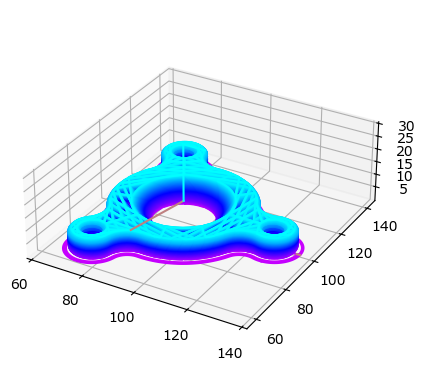

In [22]:
# add annotations and plot
import os
style='tube'
import time 
t0=time.perf_counter()
fc.transform(steps, 'plot', fc.PlotControls(style=style if not ('iPad' in os.uname().machine) else 'line',color_type='print_sequence'));
t1=time.perf_counter()
print(f'Time to cerate the FullControl preview: {(t1-t0):0.3f}s') 

In [23]:
gcode_controls = fc.GcodeControls(
    printer_name=print_parameters['printer_name'],
    save_as=print_parameters['design_name'],
    initialization_data={
        'primer': 'no_primer',
         }|print_parameters)
import time 
t0=time.perf_counter()
#gcode = fc.transform(steps, 'gcode', gcode_controls)
t1=time.perf_counter()
print(f'Time to generate G-Code file from FullControl steps: {(t1-t0):0.3f}s') 

Time to generate G-Code file from FullControl steps: 0.000s


# Appendix

## Test Layer Preview

In [24]:
from time import perf_counter
t1=perf_counter()
myTripod=Tripod(**tripodData)
p=list(myTripod())
t2=perf_counter()
print(f'Time to generate the points for one layer: {t2-t1}s')
import cProfile
cProfile.run('p=list(myTripod())',sort=1)

Time to generate the points for one layer: 0.06705025001429021s
         134806 function calls (122186 primitive calls) in 0.124 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     8827    0.032    0.000    0.046    0.000 3287678713.py:40(calibrate)
     2522    0.019    0.000    0.027    0.000 3850744835.py:24(interpolateArcChain)
13882/1262    0.016    0.000    0.123    0.000 550463442.py:59(<genexpr>)
     1261    0.007    0.000    0.043    0.000 3287678713.py:22(transform_mesh)
    37577    0.005    0.000    0.005    0.000 {built-in method builtins.abs}
     1262    0.004    0.000    0.005    0.000 149535150.py:73(Segments2Complex)
     1261    0.004    0.000    0.006    0.000 3251354716.py:21(update)
     2522    0.004    0.000    0.005    0.000 2867839790.py:10(interp)
     3783    0.003    0.000    0.004    0.000 2879178161.py:24(ISO_thread_)
     2522    0.003    0.000    0.004    0.000 2867839790.py:7(index_frac)


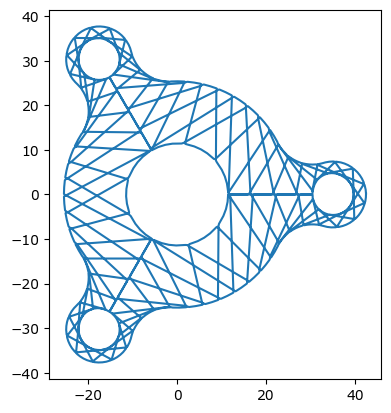

In [25]:
from matplotlib import pyplot as plt
xy=list(zip(*p))
plt.plot(*xy[:2])
plt.gca().set_aspect('equal')

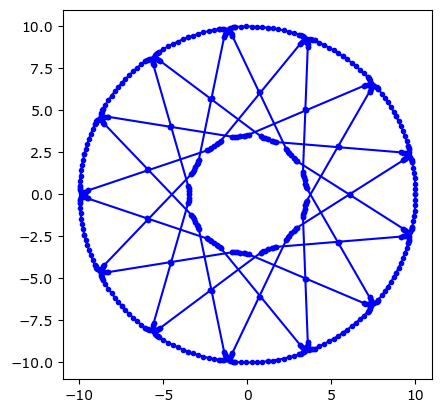

In [26]:
mesh=[(1.9332877868244882, 0.19332877868244883), (0.9388633012258815, 1.2950143724065095), (7.473407339055301, 0), (0.28796015806691877, -0.3404535276619185), (0.2114533516839284, 0.060415243338265257)]
mesh=mesh[:2]+[(mesh[2][0]/2,0)]*2+mesh[3:]#split the spoke in half
plotArcchain(plt.gca(),10,1j,(mesh+mesh[-1::-1])*13,'b.-')
plt.gca().set_aspect('equal') 

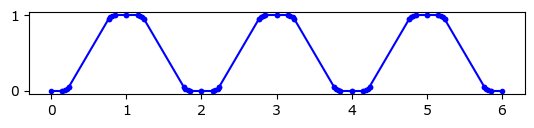

In [27]:
mesh=[(0.15, 0), (0.10412385590811431, 1.041238559081143), (1.0440306508910548, 0), (0.10412385590811431, -1.041238559081143), (0.15, 0)]
plotArcchain(plt.gca(),0,1,(mesh+mesh[-1::-1])*3,'b.-')
plt.gca().set_aspect('equal') 

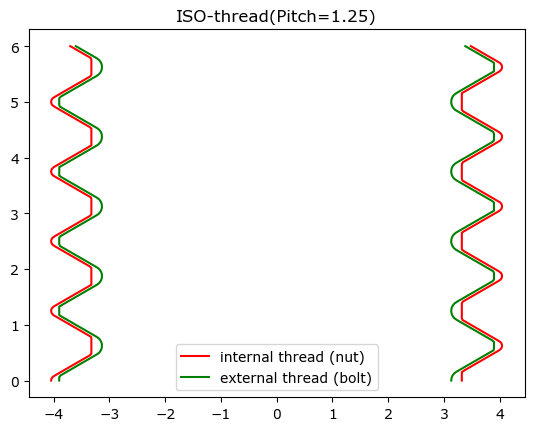

In [28]:
from matplotlib import pyplot as plt
import numpy as np
z=np.linspace(0,6,200)
M8_int=ISO_thread(Pitch=1.25)
M8_ext=ISO_thread(Pitch=1.25,External=True)
plt.plot([M8_int(z_,0.5)+4 for z_ in z],z,'r-',label='internal thread (nut)')
plt.plot([M8_ext(z_,0.5)-0.1+4 for z_ in z],z,'g-',label='external thread (bolt)')
plt.plot([-(M8_int(z_)+4) for z_ in z],z,'r-')
plt.plot([-(M8_ext(z_)-0.1+4) for z_ in z],z,'g-')
plt.title('ISO-thread(Pitch=1.25)')
plt.legend()
plt.gca().set_aspect('equal')

In [29]:
from timeit import timeit
cos_sin=pipe(iterize(lambda x:1j**(x*4/(2*pi))), iterize(lambda x:(x.real,x.imag)))
print(*('/'.join(f'{x:.5f}' for x in sc) for sc in cos_sin(iter(range(7)))),sep=', ')
print(timeit(lambda:list(cos_sin(iter(range(1000)))),number=1000))
def pipetest(x=None,/,*,description,function):
    print(f'initializing "{description}"')
    def wrapper(x,/):
        print(f'in wrapper "{description}"')
        for xi in x:
            print(f'yielding {description}({xi})={function(xi)}')
            yield function(xi)
            print(f'post yield {description}({xi})')
        print(f'post loop "{description}"')    
        return
    return wrapper(x) if x!=None else wrapper
import cmath 
print('p=pipe(...):')
p=pipe((pipetest(description='inc',function=lambda x:x+1)),None,iterize(iterize(None)),iterize(lambda x:2*x),pipetest(description='sin',function=cmath.sin),)
print('piter=p(iter(...)):')
piter=p(iter([0,10,20.0,30+0.1j]))
print('\ncalling next(piter):\n')
x=next(piter)        
print(f'x={x}')
print(f'\nrunning the loop:\n')
for i,x in enumerate(piter):
    print(f'x{i}={x}\n')

1.00000/0.00000, 0.54030/0.84147, -0.41615/0.90930, -0.98999/0.14112, -0.65364/-0.75680, 0.28366/-0.95892, 0.96017/-0.27942
1.0521343750006054
p=pipe(...):
initializing "inc"
initializing "sin"
piter=p(iter(...)):

calling next(piter):

in wrapper "sin"
in wrapper "inc"
yielding inc(0)=1
yielding sin(2)=(0.9092974268256817-0j)
x=(0.9092974268256817-0j)

running the loop:

post yield sin(2)
post yield inc(0)
yielding inc(10)=11
yielding sin(22)=(-0.008851309290403876-0j)
x0=(-0.008851309290403876-0j)

post yield sin(22)
post yield inc(10)
yielding inc(20.0)=21.0
yielding sin(42.0)=(-0.9165215479156338-0j)
x1=(-0.9165215479156338-0j)

post yield sin(42.0)
post yield inc(20.0)
yielding inc((30+0.1j))=(31+0.1j)
yielding sin((62+0.2j))=(-0.7540136550472211+0.13560123974502658j)
x2=(-0.7540136550472211+0.13560123974502658j)

post yield sin((62+0.2j))
post yield inc((30+0.1j))
post loop "inc"
post loop "sin"


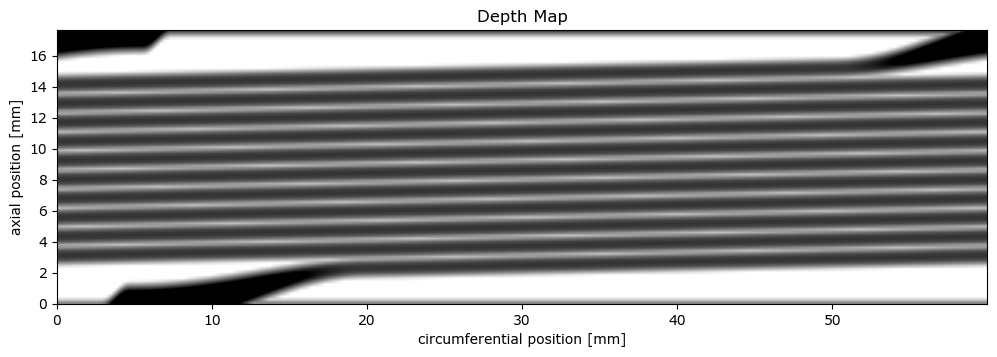

In [30]:
import numpy as np
from matplotlib import pyplot as plt
def plot_depthpattern(ax5,*,z_bottom,z_top,hl,thread_depth_pattern,r_circ,r_cable,**_):
    z=np.arange(z_bottom,z_top+hl,hl)
    phi=np.linspace(0.0,2*pi,300)
    Phi,Z=np.meshgrid(phi,z)
    R=np.vectorize(thread_depth_pattern)(Z,Phi)
    ax5.imshow(R, interpolation='bilinear', cmap='gray',
                   origin='lower', extent=[0,r_circ*2*pi, z_bottom, z_top],
                   vmax=r_circ+r_cable, vmin=r_circ-1.5*r_cable)
    ax5.set_title('Depth Map')
    ax5.set_ylabel('axial position [mm]')
    ax5.set_xlabel('circumferential position [mm]')
    ax5.set_aspect('equal')
fig=plt.figure(figsize=(12,18))
ax5=fig.add_subplot(1,1,1)
env={}
capstan(**capstan_parameters,env=env)
thread_depth_pattern=groove_depth_pattern_factory(**env)
plot_depthpattern(ax5,**env,thread_depth_pattern=thread_depth_pattern)

In [31]:
widgetList4['l_tot'].value

600.0

In [32]:
debug_view = widgets.Output(layout={'border': '1px solid black'})

@debug_view.capture(clear_output=True)
def bad_callback(event):
    print('This is about to explode')
    return 1.0 / 0.0

button = widgets.Button(
    description='click me to raise an exception',
    layout={'width': '300px'}
)
button.on_click(bad_callback)
VBox([button,debug_view])

In [33]:
env={}
Tripod(**tripodData,env=env)
', '.join(env.keys())

'z_, r_rim, r_hub, n_spokes, n_strands, phi_rim, r_fillet_rim, phi_hub, r_fillet_hub, ew_rim, ew_fillet_rim, ew_spokes, ew_fillet_hub, ew_hub, L, R1, R2, R3, R4, R5, sL, sR1, sR2, sR3, sR4, sR5, h, w_chamfer, w_chamfer1_bottom, w_chamfer1, R1_tolerance, ew_factor, n_skirt, skirt_offset, R2_tolerance, hl, hl_start, pi, deg, p0o, n0o, sss, phi3, phi4, phi5, p0i, n0i, inline, outline_stretch, inline_stretch, skirt_and_meshpoints, arc_ew, arcs, blank_points, l_layer, math, meshpoints, outline, point_data, stopcondition, transform_mesh, twist_mesh'